In [ ]:
'''
MSc students in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna
December, 2021
'''

# Assignment No. 1: recurrent neural models for sequence labeling
Part-of-speech tagging (POS) is one of the most important classification task in natural language processing. 

In this assignment we experimented a bidirectional model, along three variations, implemented with Tensorflow API, based on Keras backend, and tested the performances with different input data strategies and hyperparameters.

## Components
A.y. 2021/2022

|  Surname | Name   | Matricola   | Accademic e-mail   |  
|---|---|---|---|  
|Costanzino          | Alex   | 984919   | alex.costanzino@studio.unibo.it  |
|Costante          |  Marco  | 973866  | marco.costante@studio.unibo.it  |
|Stramiglio          | Alessandra   | 973983  | alessandr.stramiglio@studio.unibo.it  |
|Wen          | Xiaowei   | 982501  | xiaowei.wen@studio.unibo.it  |

In [ ]:
import os, shutil
import urllib.request

from zipfile import ZipFile
from natsort import natsorted

import pandas as pd
import numpy as np
import tensorflow as tf

from typing import List, Dict, OrderedDict, Tuple

from tqdm import tqdm
import gensim
import gensim.downloader as gloader

In [ ]:
!pip install git+https://github.com/artemmavrin/focal-loss.git
import focal_loss

In [ ]:
# Random seed to repeat experiments.
np.random.seed(115)
tf.random.set_seed(115)

## Dataset extraction
We decided to feed the neural networks with sentences, instead of the entire documents, since the lengths of the documents have too variability with respect to the lengths of the sentences. In this way we have a better trade-off in the padding and truncation process. 

In this section we will download the dataset from an url, split the documents according to the task and load them as dataframes.
Each step will create separate structures in order to ensure the independency of training, validation and test set.

The following routine is a simple cleaner of Colab's workspace:

In [ ]:
# Delete everything from the workspace.
def clean_workspace(f):
  if os.path.isfile(f):
    os.remove(f)
  elif os.path.isdir(f):
    list_file = os.listdir(f)
    for x in list_file:
      clean_workspace(os.path.join(os.getcwd(), f, x))
    os.rmdir(f)

Dataset downloading and extraction:

In [ ]:
dataset_url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'
dataset_folder = os.path.join(os.getcwd(), 'dataset')

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

dataset_path = os.path.join(dataset_folder, 'dependency_treebank.zip')

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(dataset_url, dataset_path)
    print('Successfully downloaded.')

unzipped_dataset_path = os.path.join(os.getcwd(), "dependency_treebank")

if os.path.exists(unzipped_dataset_path):
  clean_workspace(unzipped_dataset_path)

with ZipFile(dataset_path, 'r') as dataset:
  dataset.extractall()
  print('Successfully extracted.')


Successfully downloaded.
Successfully extracted.


In [ ]:
# We prefer to keep our files sorted accordingly to incrasing number. 
files = os.listdir(os.path.join("dependency_treebank"))
files = natsorted(files)

Dataset splitting:

In [ ]:
# Splitting the dataset into different folders.
train_folder =  os.path.join("/content", "dependency_treebank", "train")
test_folder =  os.path.join("/content", "dependency_treebank", "test")
val_folder = os.path.join("/content", "dependency_treebank", "val")

folders = [train_folder, test_folder, val_folder]

for f in folders:
  if not os.path.exists(f):
      os.makedirs(f)

for i in range (1, len(files) + 1):
  new_dest = ''
  
  if i <= 100:
    new_dest = os.path.join(train_folder, files[i-1])
  elif 100 < i <= 150:
    new_dest = os.path.join(test_folder, files[i-1])
  else:
    new_dest = os.path.join(val_folder, files[i-1])

  shutil.move(os.path.join('dependency_treebank', files[i-1]), new_dest)

## Data loading
Now we will take each sentences in the documents, with the associated tag, putting them in a new entry of the corresponding dataframe.

We will load the splits into separate dataframes, composed by three columns: `file_name`, `words`, `tags`.

They will be stored as lists so we must be careful of eventual side effects while tackling the data.

In [ ]:
def get_dict(file_name:str, word_list: list, tag_list: list) -> dict:
  return {"file_name": file_name, "words" : list(word_list), "tags" : list(tag_list)}

def load_file(file_name: str, file_path: str) -> list:
    with open(file_path, "r") as file_ds:
        sentence_list = []
        word_list = []
        tag_list = []

        dataframe_rows = {}
        
        for line in file_ds:
            splitted_row = line.split("	")

            if len(splitted_row) == 3:
                word_list.append(splitted_row[0].lower())
                tag_list.append(splitted_row[1])
              
            else:
                if len(word_list) != len(tag_list):
                  raise ValueError("Male, numero dei tag diverso da quello dei word")
                sentence_list.append(get_dict(file_name, word_list,tag_list))
                word_list = []
                tag_list = []
                dataframe_rows = {}

    if len(word_list) != 0:
      sentence_list.append(get_dict(file_name, word_list, tag_list))

    return sentence_list

def load_dataframes():
    cwd = os.getcwd()
    datasets = []

    for folder in ["train", "test", "val"]:
        data_frame = []
        current_path = os.path.join(cwd, "dependency_treebank", folder)
        ds_files = natsorted(os.listdir(current_path))
        sentences_list = []

        for ds_file in ds_files:
            sentences_list += load_file(ds_file, os.path.join(current_path, ds_file))
          
        frame = pd.DataFrame.from_dict(sentences_list)
        datasets.append(frame)

    return datasets

In [ ]:
df_train, df_val, df_test = load_dataframes()

In [ ]:
# Sanity checks.
df_train.head()
df_val.head()
df_test.head()

,file_name,words,tags
0,wsj_0151.dp,"[intelogic, trace, inc., ,, san, antonio, ,, t...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
1,wsj_0151.dp,"[the, move, boosts, intelogic, chairman, asher...","[DT, NN, VBZ, NNP, NNP, NNP, NNP, POS, NN, TO,..."
2,wsj_0151.dp,"[mr., ackerman, already, is, seeking, to, oust...","[NNP, NNP, RB, VBZ, VBG, TO, VB, NNP, NNP, IN,..."
3,wsj_0151.dp,"[the, action, followed, by, one, day, an, inte...","[DT, NN, VBN, IN, CD, NN, DT, NNP, NN, IN, PRP..."
4,wsj_0151.dp,"[in, new, york, stock, exchange, composite, tr...","[IN, NNP, NNP, NNP, NNP, JJ, NN, NN, ,, NNP, N..."


## Data Inspection
Now we will define a function that extract some infos about the dataset which can be useful while we are modelling our nets.

In [ ]:
def get_info(dataset: pd.DataFrame) -> tuple:
  number_of_sentences = len(dataset)
  max_sequence_length = max([len(sentence) for sentence in dataset['words']])
  number_of_tags = len(set(dataset['tags'].sum()))
  min_sequence_length = min([len(sentence) for sentence in dataset['words']])
  distribution_of_lengths = [len(sentence) for sentence in dataset['words']]

  return number_of_sentences, max_sequence_length, number_of_tags, min_sequence_length, distribution_of_lengths

We will now check the distrubition of the lenghts in the training and validation set to seek a good sequence lenght for the LSTMs.

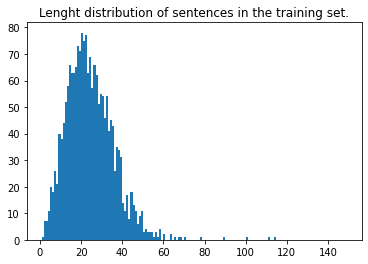

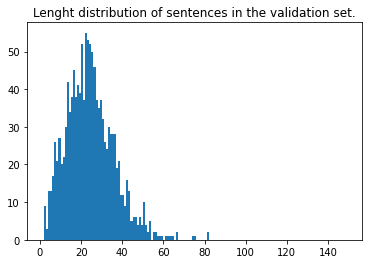

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
n_t, _, _ = plt.hist(get_info(df_train)[-1], bins = [i for i in range(1, 150)], cumulative = False)
plt.title('Length distribution of sentences in the training set.');

plt.figure()
n_v, _, _ = plt.hist(get_info(df_val)[-1], bins = [i for i in range(1, 150)], cumulative = False)
plt.title('Length distribution of sentences in the validation set.');

For training, as maximum sequence length we considered 95th percentile of the lengths of the sentences of the training set.

In our case we know that such length can be used also for testing, since the maximum length of the sentences of the test set is way shorter. 
In a real-case scenario, where the test set is unknown, we should be careful when managing the test set to make inference, since we cannot truncate its sentences, otherwise it would change it, altering the performances.

In [ ]:
maximum_sequence_length = round(np.percentile(n_t, 95))
print(f'The 0.95 percentile of the sequences lengths in the training set is {maximum_sequence_length}.')

The 0.95 percentile of the sequences lengths in the training set is 66.


## Data processing
Now we will create routine to handle the download of GloVe embedding, the creation of embedding matrix and the out-of-vocaboulary words.

### Out-Of-Vocaboulary words
First we define a routine that extracts from each dataset the set of unique words to seek for OOVs.

In [ ]:
def get_word_listing(dataframe: pd.DataFrame):
  return set(dataframe["words"].sum())

Then we define a function that checks the OOVs.

In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    '''
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.
    '''

    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

### Vocaboularies creation

In [ ]:
from collections import OrderedDict
from typing import OrderedDict

def build_vocabulary(df: pd.DataFrame) -> (OrderedDict[int, str], OrderedDict[str, int], OrderedDict[int, str], OrderedDict[str, int]):
    '''
    Given a dataset, builds the corresponding word vocabulary.
    '''

    idx2word = OrderedDict()
    word2idx = OrderedDict()

    idx2tag = OrderedDict()
    tag2idx = OrderedDict()
    
    curr_idx = 1 # Start at 1 since 0 is reserved for padding.
    for token in tqdm(df['words'].sum()):
        if token not in word2idx:
            word2idx[token] = curr_idx
            idx2word[curr_idx] = token
            curr_idx += 1

    curr_idx = 1 # Start at 1 since 0 is reserved for padding.
    for tag in tqdm(np.unique(df['tags'].sum())):
        if tag not in tag2idx:
            tag2idx[tag] = curr_idx
            idx2tag[curr_idx] = tag
            curr_idx += 1

    return idx2word, word2idx, idx2tag, tag2idx

### Embedding

In [ ]:
def load_glove_embedding(embedding_dimension: int) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    # Sanity check.
    try:
        embedded_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding dimension: choose between: 50, 100, 200, 300.")
        raise e

    return embedded_model

embedding_dimension = 300
embedding_model = load_glove_embedding(embedding_dimension) # Load embedding model with the chosen dimensionality.

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors, embedding_dimension: int,
                           word2idx: Dict[str, int], vocab_size: int, oov_terms: List[str]) -> np.ndarray:
    '''
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model.
    '''

    # Note: we take (vocab_size) + 1 since we start counting by 1, having reserved 0 for the padding.
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dimension), dtype = np.float32) 

    for word, idx in tqdm(word2idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low = -0.05, high = 0.05, size = embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

### Matrix dataset preparation
Now we will put our data in form of matrixes to feed the models.

In [ ]:
# Step 1: creation of vocaboulary for the training set and extraction of his OOVs.
idx2word_train, word2idx_train, idx2tag_train, tag2idx_train = build_vocabulary(df_train)

oov_terms_train = check_OOV_terms(embedding_model, get_word_listing(df_train))
print(f'There are {len(oov_terms_train)} OOVs in the training set.')

embedding_matrix_train = build_embedding_matrix(embedding_model, embedding_dimension, word2idx_train, len(word2idx_train), oov_terms_train)
print("Embedding matrix shape: {}".format(embedding_matrix_train.shape))

print('\n')
# Step 2: creation of vocaboulary for the validation set and extraction of his OOVs, taking into account the ones already from training set.
idx2word_val, word2idx_val, idx2tag_val, tag2idx_val = build_vocabulary(df_val)

oov_terms_val = check_OOV_terms(embedding_model, get_word_listing(df_val))
oov_terms_val = list(set(oov_terms_val).difference(set(oov_terms_train)))
print(f'There are {len(oov_terms_val)} new OOVs in the validation set.')

embedding_matrix_val = build_embedding_matrix(embedding_model, embedding_dimension, word2idx_val, len(word2idx_val), oov_terms_val)
print("Embedding matrix shape: {}.".format(embedding_matrix_val.shape))

print('\n')
# Step 3: creation of vocaboulary for the test set and extraction of his OOVs.
idx2word_test, word2idx_test, idx2tag_test, tag2idx_test = build_vocabulary(df_test)

oov_terms_test = check_OOV_terms(embedding_model, get_word_listing(df_test))
oov_terms_test = list(set(oov_terms_test).difference((set(oov_terms_train).union(set(oov_terms_val)))))
print(f'There are {len(oov_terms_test)} new OOVs in the test set.')

embedding_matrix_test = build_embedding_matrix(embedding_model, embedding_dimension, word2idx_test, len(word2idx_test), oov_terms_test)
print("Embedding matrix shape: {}.".format(embedding_matrix_test.shape))

print('\n')

# Whole embedding matrix.
embedding_matrix = np.concatenate((embedding_matrix_train, embedding_matrix_val, embedding_matrix_test))
print("Embedding matrix shape: {}.".format(embedding_matrix.shape))

#idx2word, word2idx, idx2tag, tag2idx = build_vocabulary(pd.concat([df_train, df_val, df_test]))

100%|██████████| 45/45 [00:00<00:00, 56816.28it/s]


There are 359 OOVs in the training set.


100%|██████████| 7404/7404 [00:00<00:00, 181660.18it/s]


Embedding matrix shape: (7405, 300)




100%|██████████| 44/44 [00:00<00:00, 184919.21it/s]


There are 189 new OOVs in the validation set.


100%|██████████| 5420/5420 [00:00<00:00, 166954.02it/s]


Embedding matrix shape: (5421, 300).




100%|██████████| 40/40 [00:00<00:00, 103627.03it/s]


There are 128 new OOVs in the test set.


100%|██████████| 3407/3407 [00:00<00:00, 165508.38it/s]

Embedding matrix shape: (3408, 300).


Embedding matrix shape: (16234, 300).


At first we created the vocabularies of words and tags for the training set, we extracted the out-of-vocabularies (OOV) words for it and then its embedding matrix.
We assigned random vectors for the OOV words.
We repeated the same process for the validation set, taking into account the fact that the OOV words already considered for the training set, are not OOV words for the validation set. The same was done for the test set.

Then, we concatenated all embedding matrixes into a single one, and merged the various vocabularies into a single one.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from typing import OrderedDict

def get_matrixes(dataframe: pd.DataFrame, max_sequence_length: int, word2idx: OrderedDict[str, int], tag2idx: OrderedDict[str, int]) -> (np.ndarray, np.ndarray):
  # Transform all words in the dataframe into their corresponding index.
  word_matrix = [[word2idx[dataframe['words'][j][i]] # j selects the row, i selects the word.
                for i in range(len(dataframe['words'][j]))] 
                for j in range(len(dataframe))] 

  tag_matrix = [[tag2idx[dataframe['tags'][j][i]] # j selects the row, i selects the word.
               for i in range(len(dataframe['tags'][j]))] 
               for j in range(len(dataframe))] 

  # Turn the list of lists into a matrix.
  for i in range(len(word_matrix)):
    word_matrix[i] = np.asarray(word_matrix[i])
      
  word_matrix = np.asarray(word_matrix);

  for i in range(len(tag_matrix)):
    tag_matrix[i] = np.asarray(tag_matrix[i])
  
  tag_matrix = np.asarray(tag_matrix);

  # Pad the sequences into the same length. Note that we need to pad to right since it's needed for Keras masking system.
  word_matrix = pad_sequences(word_matrix, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
  tag_matrix = pad_sequences(tag_matrix, maxlen = max_sequence_length, padding = 'post', truncating = 'post')

  # Add dimension to tag matrix to conform it to the net.
  tag_matrix = np.expand_dims(tag_matrix, axis = 2)

  return word_matrix, tag_matrix

In [ ]:
word2idx = OrderedDict()

word2idx.update(word2idx_train)
word2idx.update(word2idx_test)
word2idx.update(word2idx_val)

tag2idx = OrderedDict()

tag2idx.update(tag2idx_train)
tag2idx.update(tag2idx_test)
tag2idx.update(tag2idx_val)

Finally, we put our dataframes into matrixes, padding and truncating the sentences, using the aforementioned vocabulary to encode the words into integers.

In [ ]:
training = get_matrixes(df_train, maximum_sequence_length, word2idx, tag2idx)
validation = get_matrixes(df_val, maximum_sequence_length, word2idx, tag2idx)
test = get_matrixes(df_test, maximum_sequence_length, word2idx, tag2idx)

print(f'The training set contains {training[0].shape[0]} sentences, has a maximum sequence length of {get_info(df_train)[1]} and a minimum of {get_info(df_train)[3]}.')
print(f'The validation set contains {validation[0].shape[0]} sentences, has a maximum sequence length of {get_info(df_val)[1]} and a minimum of {get_info(df_val)[3]}.')
print(f'The test set contains {test[0].shape[0]} sentences, has a maximum sequence length of {get_info(df_test)[1]} and a minimum of {get_info(df_val)[3]}.')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


The training set contains 1963 sentences, has a maximum sequence length of 249 and a minimum of 1.
The validation set contains 1299 sentences, has a maximum sequence length of 81 and a minimum of 2.
The test set contains 652 sentences, has a maximum sequence length of 58 and a minimum of 2.


### Weights for unbalanced dataset
We also created a vector of weights for each POS tagging classes, to take into account the unbalance of the dataset, based on their inverse frequency.
The weights are amplified with a constant factor to avoid too low loss function during training, since it would be more difficult to track.

In [ ]:
def scale01(arr: np.ndarray):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [ ]:
# Obtain weighting for all the classes.
unique, counts = np.unique(np.squeeze(training[1], axis = -1), return_counts = True)
inverse_count = 1/counts

weights = dict(zip(unique, inverse_count))

weights_list = np.array(list(weights.values()))
weights_list = 1e4 * scale01(weights_list) # Amplify weights to better visualize loss.
weights_list

array([0.00000000e+00, 1.00000000e+04, 3.12272078e+01, 2.49418259e+01,
       3.86933702e+00, 1.95959672e+02, 1.85066294e+02, 5.00713295e+00,
       3.70540372e+01, 8.72853042e+00, 6.95108715e+00, 2.33469112e+00,
       2.03962970e+02, 4.99993943e+03, 1.90031731e+00, 3.23686474e+00,
       6.35739048e+01, 1.07407050e+02, 9.99890979e+02, 2.42694051e+01,
       1.48067911e+00, 1.84700605e+00, 1.05143299e+02, 3.21335090e+00,
       1.11100344e+03, 2.46930621e+01, 1.03831946e+01, 2.43889665e+01,
       6.59486377e+00, 1.16159344e+02, 5.26201031e+02, 7.13083024e+01,
       1.00000000e+04, 9.61608199e+00, 1.00000000e+04, 8.27527303e+00,
       6.34306811e+00, 1.29851844e+01, 9.60660999e+00, 1.36341905e+01,
       8.70509794e+00, 4.88990673e+01, 7.08017106e+01, 1.66656572e+03,
       1.09770307e+02, 2.43290396e+01])

## Models

### Baseline model:  bidirectional LSTM with fully connected layer
We created a baseline model, composed by three layers: a non-trainable embedding layer, that also takes into account the masking of the 0s used for padding, a bidirectional LSTM layer with a dense layer on top for classification.
The dense layer has the same number of nodes of the considered tags plus one, since we reserved 0 for padding.

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, TimeDistributed, Input, Masking, Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

hidden_nodes = 128
number_of_tags = get_info(df_train)[2] + 1 # Note: +1 since we reserved 0 for padding.

sequence_input = Input(shape = (maximum_sequence_length, ))
#masked_input = Masking(mask_value = 0)(sequence_input)

embedding_layer = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = 300,
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(sequence_input)

lstm_layer = Bidirectional(LSTM(hidden_nodes, return_sequences = True, dropout = 0.20, recurrent_dropout = 0.10))(embedding_layer)
sequence_output = TimeDistributed(Dense(number_of_tags, activation = 'softmax'))(lstm_layer)

bidirect_model = Model(sequence_input, sequence_output)

# Compile the model.
initial_learning_rate = 0.001
scheduler = ExponentialDecay(initial_learning_rate,
                             decay_steps = 100000,
                             decay_rate = 0.96,
                             staircase = True)

bidirect_model.compile(loss = 'sparse_categorical_crossentropy', 
                       #loss = focal_loss.SparseCategoricalFocalLoss(gamma = 2, class_weight = weights_list),
                       optimizer = RMSprop(learning_rate = scheduler),
                       metrics = ['acc'])

# Check if the structure is correct.
bidirect_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 66)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 66, 300)           4870200   
                                                                 
 bidirectional_6 (Bidirectio  (None, 66, 256)          439296    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 66, 46)           11822     
 tributed)                                                       
                                                                 
Total params: 5,321,318
Trainable params: 451,118
Non-trainable params: 4,870,200
_________________________________________________________________


For embedding we decided to choose the maximum available dimension for GloVe (300) to have the best possible representation.

We performed a grid search between [16; 256], stepping with powers of two, to choose the number of hidden nodes of the LSTM layer: we obtained as best result 128 hidden nodes. We chose to dropout the 20\% of nodes and the 10\% of recurrent nodes of the LSTM layer.

We trained our networks with RMSprop optimizer, using a learning rate scheduler that decays exponentially the rate, which starts at 0.001. We also tried Adam optimizer, but adaptative methods seems to stall the learning. 

As loss we used sparse categorical cross-entropy with softmax activation function for the last layer since we worked with integer labels. We also tried sparse categorical focal loss with class weights to enhance the dataset unbalance, but it turned out too difficult to optimize.

To early stop the training we tracked the validation loss, with a patience of 5 epochs, since the validation accuracy also takes into account the classes that we would later discard for evaluation.

In [ ]:
checkpoint = [EarlyStopping(monitor = "val_loss", 
                            patience = 5,
                            verbose = 1,
                            mode = "auto")]

In [ ]:
# Train the model.
bidirect_model.fit(x = training[0], y = training[1], 
                   epochs = 50, callbacks = checkpoint,
                   validation_data = (validation[0], validation[1]))

Epoch 1/50
62/62 [==============================] - 44s 603ms/step - loss: 0.7279 - acc: 0.4718 - val_loss: 0.5629 - val_acc: 0.5571
Epoch 2/50
62/62 [==============================] - 37s 591ms/step - loss: 0.4491 - acc: 0.6505 - val_loss: 0.4406 - val_acc: 0.6367
Epoch 3/50
62/62 [==============================] - 36s 588ms/step - loss: 0.3592 - acc: 0.7113 - val_loss: 0.3782 - val_acc: 0.6902
Epoch 4/50
62/62 [==============================] - 37s 592ms/step - loss: 0.3118 - acc: 0.7460 - val_loss: 0.3543 - val_acc: 0.7047
Epoch 5/50
62/62 [==============================] - 37s 595ms/step - loss: 0.2803 - acc: 0.7681 - val_loss: 0.3304 - val_acc: 0.7252
Epoch 6/50
62/62 [==============================] - 36s 588ms/step - loss: 0.2548 - acc: 0.7873 - val_loss: 0.3169 - val_acc: 0.7375
Epoch 7/50
62/62 [==============================] - 37s 598ms/step - loss: 0.2330 - acc: 0.8062 - val_loss: 0.3028 - val_acc: 0.7486
Epoch 8/50
62/62 [==============================] - 37s 596ms/step - 

### Variation No. 1: bidirectional GRU with fully connected layer

In [ ]:
from tensorflow.keras.layers import GRU, Bidirectional, Dense, TimeDistributed, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

hidden_nodes = 128
number_of_tags = get_info(df_train)[2] + 1 # Note: +1 since we reserved 0 for padding.

sequence_input = Input(shape = (maximum_sequence_length, ))
#masked_input = Masking(mask_value = 0)(sequence_input)

embedding_layer = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = 300,
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(sequence_input)

lstm_layer = Bidirectional(GRU(hidden_nodes, return_sequences = True, dropout = 0.20, recurrent_dropout = 0.10))(embedding_layer)
sequence_output = TimeDistributed(Dense(number_of_tags, activation = 'softmax'))(lstm_layer)

bidirect_model_v1 = Model(sequence_input, sequence_output)

# Compile the model.
initial_learning_rate = 0.001
scheduler = ExponentialDecay(initial_learning_rate,
                             decay_steps = 100000,
                             decay_rate = 0.96,
                             staircase = True)

bidirect_model_v1.compile(loss = 'sparse_categorical_crossentropy', 
                          #loss = focal_loss.SparseCategoricalFocalLoss(gamma = 2, class_weight = weights_list),
                          optimizer = RMSprop(learning_rate = scheduler),
                          metrics = ['acc'])

# Check if the structure is correct.
bidirect_model_v1.summary()

checkpoint = [EarlyStopping(monitor = "val_loss", 
                            patience = 5,
                            verbose = 1,
                            mode = "auto")]

# Train the model.
bidirect_model_v1.fit(x = training[0], y = training[1], epochs = 50, callbacks = checkpoint, validation_data = (validation[0], validation[1]))

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 66)]              0         
                                                                 
 embedding_17 (Embedding)    (None, 66, 300)           4870200   
                                                                 
 bidirectional_9 (Bidirectio  (None, 66, 256)          330240    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 66, 46)           11822     
 tributed)                                                       
                                                                 
Total params: 5,212,262
Trainable params: 342,062
Non-trainable params: 4,870,200
_________________________________________________________________
Epoch 1/50
62/62 [=========================

### Variation No. 2: double bidirectional LSTM with fully connected layer

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, TimeDistributed, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

hidden_nodes = 128
number_of_tags = get_info(df_train)[2] + 1 # Note: +1 since we reserved 0 for padding.

sequence_input = Input(shape = (maximum_sequence_length, ))
#masked_input = Masking(mask_value = 0)(sequence_input)

embedding_layer = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = 300,
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(sequence_input)

lstm_layer_1 = Bidirectional(LSTM(hidden_nodes, return_sequences = True, dropout = 0.20, recurrent_dropout = 0.10))(embedding_layer)
lstm_layer_2 = Bidirectional(LSTM(hidden_nodes, return_sequences = True, dropout = 0.20, recurrent_dropout = 0.10))(lstm_layer_1)
sequence_output = TimeDistributed(Dense(number_of_tags, activation = 'softmax'))(lstm_layer_2)

bidirect_model_v2 = Model(sequence_input, sequence_output)

# Compile the model.
initial_learning_rate = 0.001
scheduler = ExponentialDecay(initial_learning_rate,
                             decay_steps = 100000,
                             decay_rate = 0.96,
                             staircase = True)

bidirect_model_v2.compile(loss = 'sparse_categorical_crossentropy', 
                          #loss = focal_loss.SparseCategoricalFocalLoss(gamma = 2, class_weight = weights_list),
                          optimizer = RMSprop(learning_rate = scheduler),
                          metrics = ['acc'])

# Check if the structure is correct.
bidirect_model_v2.summary()

checkpoint = [EarlyStopping(monitor = 'val_loss', 
                            patience = 5,
                            verbose = 1,
                            mode = "auto")]

# Train the model.
bidirect_model_v2.fit(x = training[0], y = training[1], epochs = 50, callbacks = checkpoint, validation_data = (validation[0], validation[1]))

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 66)]              0         
                                                                 
 embedding_18 (Embedding)    (None, 66, 300)           4870200   
                                                                 
 bidirectional_10 (Bidirecti  (None, 66, 256)          439296    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 66, 256)          394240    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 66, 46)           11822     
 stributed)                                                      
                                                          

### Variation No. 3: bidirectional LSTM with double fully connected layer
For the last variation we doubled the number of hidden nodes of the first dense layer.

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, TimeDistributed, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

hidden_nodes = 128
number_of_tags = get_info(df_train)[2] + 1 # Note: +1 since we reserved 0 for padding.

sequence_input = Input(shape = (maximum_sequence_length, ))
#masked_input = Masking(mask_value = 0)(sequence_input)

embedding_layer = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = 300,
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(sequence_input)

lstm_layer = Bidirectional(LSTM(hidden_nodes, return_sequences = True, dropout = 0.20, recurrent_dropout = 0.10))(embedding_layer)
dense_layer = TimeDistributed(Dense(2 * number_of_tags, activation = 'softmax'))(lstm_layer)
sequence_output = TimeDistributed(Dense(number_of_tags, activation = 'softmax'))(dense_layer)

bidirect_model_v3 = Model(sequence_input, sequence_output)

# Compile the model.
initial_learning_rate = 0.001
scheduler = ExponentialDecay(initial_learning_rate,
                             decay_steps = 100000,
                             decay_rate = 0.96,
                             staircase = True)

bidirect_model_v3.compile(loss = 'sparse_categorical_crossentropy', 
                          #loss = focal_loss.SparseCategoricalFocalLoss(gamma = 2, class_weight = weights_list),
                          optimizer = RMSprop(learning_rate = scheduler),
                          metrics = ['acc'])

# Check if the structure is correct.
bidirect_model_v3.summary()

checkpoint = [EarlyStopping(monitor = "val_loss", 
                            patience = 5,
                            verbose = 1,
                            mode = "auto")]

# Train the model.
bidirect_model_v3.fit(x = training[0], y = training[1], epochs = 50, callbacks = checkpoint, validation_data = (validation[0], validation[1]))

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 66)]              0         
                                                                 
 embedding_22 (Embedding)    (None, 66, 300)           4870200   
                                                                 
 bidirectional_15 (Bidirecti  (None, 66, 256)          439296    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 66, 92)           23644     
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 66, 46)           4278      
 stributed)                                                      
                                                          

 ## Evaluation

In [ ]:
tag2idx

OrderedDict([('#', 1),
             ('$', 2),
             ("''", 3),
             (',', 4),
             ('-LRB-', 5),
             ('-RRB-', 6),
             ('.', 7),
             (':', 8),
             ('CC', 9),
             ('CD', 10),
             ('DT', 11),
             ('EX', 12),
             ('FW', 13),
             ('IN', 14),
             ('JJ', 15),
             ('JJR', 16),
             ('JJS', 17),
             ('LS', 18),
             ('MD', 19),
             ('NN', 20),
             ('NNP', 21),
             ('NNPS', 22),
             ('NNS', 23),
             ('PDT', 24),
             ('POS', 25),
             ('PRP', 26),
             ('PRP$', 27),
             ('RB', 28),
             ('RBR', 29),
             ('RBS', 30),
             ('RP', 31),
             ('SYM', 32),
             ('TO', 32),
             ('UH', 33),
             ('VB', 34),
             ('VBD', 35),
             ('VBG', 36),
             ('VBN', 37),
             ('VBP', 38),
             ('

In [ ]:
punctuation_indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 44]
meaningful_classes = list(set([i for i in range(0,45)]).difference(set(punctuation_indexes)))
print(f'The meaningful classes are: {meaningful_classes}.')

The meaningful classes are: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43].


35

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score

def evaluate_model(model: tf.keras.Model, test_matrix: np.ndarray):
  prediction = model.predict(test_matrix[0]) # Evaluate the test set.

  prediction = np.argmax(prediction, axis = -1) # Get the class with the highest index.
  #prediction = np.expand_dims(prediction, axis = -1) # Add dimension to to conform it to the prediction.

  print(f'Evaluation for model {model}.')
  print(classification_report(y_true = np.squeeze(test_matrix[1], axis = -1).ravel(), y_pred = prediction.ravel(), zero_division = 0, labels = meaningful_classes))


  print(f'The f1-score, calculated on the meaningful classes of the test set, is: {f1_score(y_true = np.squeeze(test_matrix[1], axis = -1).ravel(), y_pred = prediction.ravel(), average = "macro", zero_division = 0, labels = meaningful_classes)}.')
  print(f'The global accuracy score on the test set is: {accuracy_score(y_true = np.squeeze(test_matrix[1], axis = -1).ravel(), y_pred = prediction.ravel())}.')

  return confusion_matrix(y_true = np.squeeze(test_matrix[1], axis = -1).ravel(), y_pred = prediction.ravel(), labels = meaningful_classes)

The best models are variation one and two.


In [ ]:
#cf = evaluate_model(bidirect_model, test)
cf_v1 = evaluate_model(bidirect_model_v1, test)
cf_v2 = evaluate_model(bidirect_model_v2, test)
#cf_v3 = evaluate_model(bidirect_model_v3, test)

Evaluation for model <keras.engine.functional.Functional object at 0x7fbebd410d10>.
              precision    recall  f1-score   support

           9       0.98      1.00      0.99       366
          10       0.92      0.78      0.85       858
          11       0.97      0.98      0.98      1335
          12       0.71      1.00      0.83         5
          13       1.00      1.00      1.00         0
          14       0.95      0.96      0.95      1630
          15       0.58      0.63      0.60       918
          16       0.65      0.56      0.60        59
          17       0.77      0.65      0.70        31
          18       0.00      1.00      0.00         0
          19       0.95      0.99      0.97       167
          20       0.69      0.80      0.74      2383
          21       0.79      0.53      0.63      1504
          22       0.25      0.02      0.04        44
          23       0.67      0.69      0.68       941
          24       1.00      0.00      0.00        

To calculate the F1-score we discarded the classes with null support in the test set. We could also consider their prediction 1 or 0, but we would overestimate or underestimate the score. The choice is application-dependent.
This is also the reason why we obtained such low accuracy scores on the test set.

In [ ]:
import math

def compute_custom_metrics(conf_mat : np.ndarray):  
  accuracies, precisions, recalls, f1_scores = dict(), dict(), dict(), dict()

  for i in range(len(conf_mat)):
    TP = conf_mat[i,i]
    FN = np.sum(conf_mat[i,:]) - conf_mat[i,i]
    FP = np.sum(conf_mat[:,i]) - conf_mat[i,i]
    TN = np.sum(conf_mat) - TP - FP - FN

    accuracies[i] =  (TP + TN) / (TP + FP + FN + TN)
    precisions[i] =  TP / (TP + FP)
    recalls[i] = TP / (TP + FN)
    f1_scores[i] = 2 * (recalls[i] * precisions[i]) / (recalls[i] + precisions[i])

  f1_scores_pruned = dict()

  for k,v in f1_scores.items():
    if math.isnan(v) == False:
      f1_scores_pruned[k] = v

  global_accuracy = np.mean(list(accuracies.values()))
  macro_f1 = np.mean(list(f1_scores_pruned.values()))

  print(f'The global accuracy for the given confusion matrix is {global_accuracy}, with an f1-score of {macro_f1}.')

  return global_accuracy, macro_f1

Note, the accuracy displayed down here is referred to only the considered classes, with support. Actually global accuracy considers them all.

In [ ]:
compute_custom_metrics(cf_v1)

The global accuracy for the given confusion matrix is 0.9881545351806119, with an f1-score of 0.7571027270448055.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


(0.9881545351806119, 0.7571027270448055)

In [ ]:
compute_custom_metrics(cf_v2)

The global accuracy for the given confusion matrix is 0.9883092131442812, with an f1-score of 0.7421710391633364.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


(0.9883092131442812, 0.7421710391633364)